# Bag of Visual Words Image Classification, Week 2

In [1]:
import cv2
import numpy as np
import pandas as pd
import pickle as cPickle
from matplotlib import pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score,confusion_matrix,multilabel_confusion_matrix,recall_score
from sklearn.preprocessing import normalize
from sklearn import svm
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import time

## Environment setup

In [2]:
train_images_filenames = cPickle.load(open('resources/train_images_filenames.dat','rb'))
test_images_filenames = cPickle.load(open('resources/test_images_filenames.dat','rb'))
train_labels = cPickle.load(open('resources/train_labels.dat','rb'))
test_labels = cPickle.load(open('resources/test_labels.dat','rb'))

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
SIFTdetector = cv2.SIFT_create(nfeatures=300)

In [5]:
def compute_dense_sift(gray,sift,step):
    step_size = step
    kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) 
                                        for x in range(0, gray.shape[1], step_size)]
    dense_feat = sift.compute(gray, kp)
    dense_feat_des = dense_feat[1]
    return dense_feat_des

In [7]:
def get_pyramid_image_cells(image,level):
    # CURRENTLY WORKING ONLY FOR LEVELS 0,1,2 (1,4, and 16 cells)
    M = (image.shape[0])//(level+1)
    N = (image.shape[1])//(level+1)
    tiles = [image[x:x+M,y:y+N] for x in range(0,image.shape[0],M) for y in range(0,image.shape[1],N)]

    return tiles

## 1. Tweaking parameters for SVM with GridSearchCV Cross Validation

SVM kernels have different parameters that should be tuned.
In order to choose the optimal values for these parameters, we used the cross-validation estimator <em>GridSearchCV</em>.

We will be estimating the optimal parameters for two different SVM kernels: linear and rbf. 
A third kernel based on Histogram Intersection will be used in this project in further sections.

The parameters to estimate and the values tested in this section are:
* Linear Kernel:
    * Regularization parameter, C: [1,...,20]
* Kernel coeffiient
    * Regularization parameter, C: [1, 10, 100, 1000, 2000, 3000, 5000]
    * Kernel coefficient, gamma: [0, .001, .003, .01, .03, .1, .3, 1, 1.5]

Parameters related to the Bag of Visual Words implemented in the previous weeek are those that proved to perform best in said delivery. These are:

* Dense SIFT for keypoint computation with step=5 (different densities to be tested in further sections)
* Codebook size=128

In [8]:
step=5

today = datetime.now()
dt_string = today.strftime("%H:%M:%S")
print(f"{dt_string} started doing step={step}")

Train_descriptors = []
Train_label_per_descriptor = []

for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
#     kpt,des=SIFTdetector.detectAndCompute(gray,None)
    des=compute_dense_sift(gray,SIFTdetector, step)
    Train_descriptors.append(des)
    Train_label_per_descriptor.append(labels)

D=np.vstack(Train_descriptors)

k=128
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook.fit(D)

visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
for i in range(len(Train_descriptors)):
    words=codebook.predict(Train_descriptors[i])
    visual_words[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1))

# knn = KNeighborsClassifier(n_neighbors=37,n_jobs=-1,metric='manhattan')
# knn.fit(visual_words, train_labels)

today = datetime.now()
dt_string = today.strftime("%H:%M:%S")
print(f"{dt_string} started doing step={step}")


20:19:17 started doing step=5
20:20:43 started doing step=5


In [35]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0,.001,.003,.01,.03,.1,.3,1,1.5],
                     'C': [1, 10, 100, 1000, 2000, 3000, 5000]},
                    {'kernel': ['linear'], 'C': [i for i in range(1,20,1)]}]

scores = ['precision_macro', 'recall_macro','accuracy']

today = datetime.now()
dt_string = today.strftime("%H:%M:%S")
print(f"{dt_string} started doing step={step}")

data_results=[]

for score in scores:
    #print("# Tuning hyper-parameters for %s" % score)
    #print()

    clf = GridSearchCV(
        SVC(), tuned_parameters, scoring=score
    )
    clf.fit(visual_words, train_labels)

    #print("Best parameters set found on development set:")
    #print()
    #print(clf.best_params_)
    #print()
    #print("Grid scores on development set:")
    #print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        c=params['C']
        ker=params['kernel']
        if ker=='rbf': 
            gamma=params['gamma']
        else: gamma=None
            
        data_results.append([mean,std,c,gamma,ker,score])
        
        #print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
    #print()


today = datetime.now()
dt_string = today.strftime("%H:%M:%S")
print(f"{dt_string} started doing step={step}")

20:57:07 started doing step=5
21:02:26 started doing step=5


In [10]:
df=pd.DataFrame(data_results, columns=['mean_val','std_val','c','gamma','ker','score'])

In [38]:
def plot_data(x,y,x_label, y_label, title):
    plt.figure(figsize=(9,6))
    plt.title(title)
    plt.plot(x,y, marker='.')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

The results of the parameter estimation will be analysed in terms of accuracy.
The following code produces 3 different plots. Two of which describe the Kernel parameter estimation (C and gamma) and the remaining plot is that of the Linear Kernel (C value).
These results are discussed below.

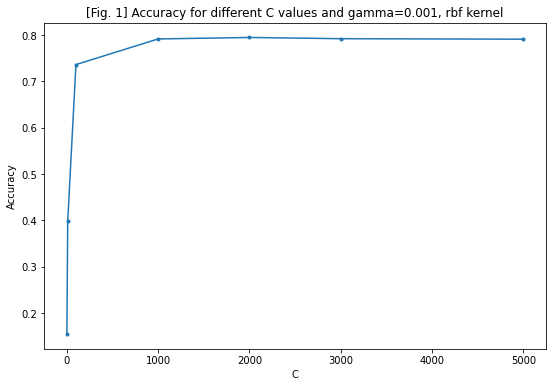

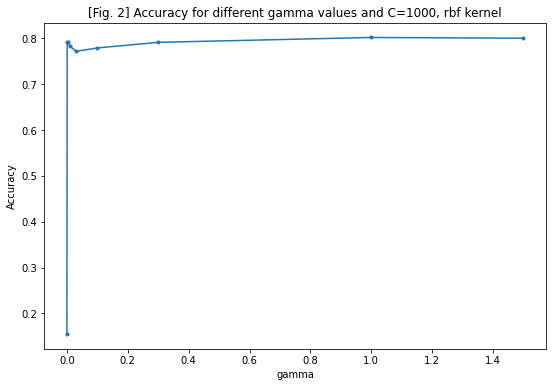

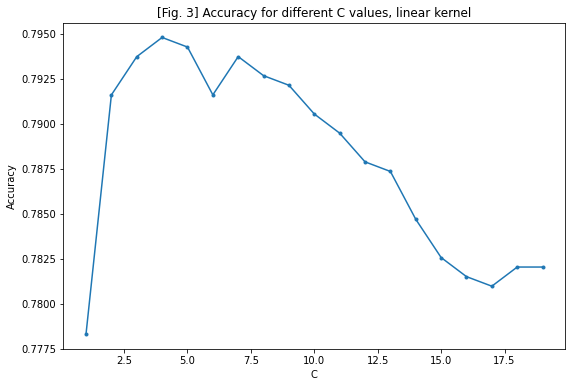

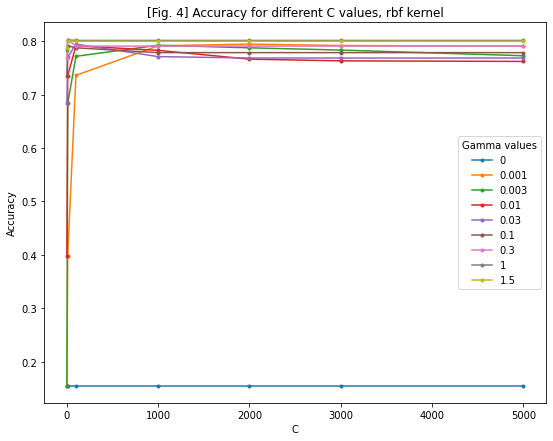

In [43]:
###### RBF KERNEL ###### 
rbf = df[(df.ker == 'rbf')]
# C VALUES
precision_c_values_rbf = rbf[(rbf.gamma==0.0010)&(rbf.score=='precision_macro')]['mean_val'].tolist()
recall_c_values_rbf = rbf[(rbf.gamma==0.0010)&(rbf.score=='recall_macro')]['mean_val'].tolist()
accuracy_c_values_rbf = rbf[(rbf.gamma==0.0010)&(rbf.score=='accuracy')]['mean_val'].tolist()


# GAMMA VALUES
precision_gamma_values_rbf = rbf[(rbf.c==1000)&(rbf.score=='precision_macro')]['mean_val'].tolist()
recall_gamma_values_rbf = rbf[(rbf.c==1000)&(rbf.score=='recall_macro')]['mean_val'].tolist()
accuracy_gamma_values_rbf = rbf[(rbf.c==1000)&(rbf.score=='accuracy')]['mean_val'].tolist()


###### LINEAR KERNEL ###### 
linear = df[(df.ker == 'linear')]
precision_c_values_linear = linear[(linear.score=='precision_macro')]['mean_val'].tolist()
recall_c_values_linear = linear[(linear.score=='recall_macro')]['mean_val'].tolist()
accuracy_c_values_linear = linear[(linear.score=='accuracy')]['mean_val'].tolist()


# Accuracy
C_values_rbf=[1, 10, 100, 1000, 2000, 3000,5000]
C_values_linear=[i for i in range(1,20,1)]
gamma_values=[0,.001,.003,.01,.03,.1,.3,1,1.5]
plot_data(C_values_rbf,accuracy_c_values_rbf,'C','Accuracy','[Fig. 1] Accuracy for different C values and gamma=0.001, rbf kernel')
plot_data(gamma_values,accuracy_gamma_values_rbf,'gamma','Accuracy','[Fig. 2] Accuracy for different gamma values and C=1000, rbf kernel')
plot_data(C_values_linear,accuracy_c_values_linear,'C','Accuracy','[Fig. 3] Accuracy for different C values, linear kernel')

plt.figure(figsize=(9,7))
plt.title('[Fig. 4] Accuracy for different C values, rbf kernel')
for gamma_value in gamma_values:
    accuracy=rbf[(rbf.gamma==gamma_value)&(rbf.score=='accuracy')]['mean_val'].tolist()
    plt.plot(C_values_rbf,accuracy, marker='.',label=str(gamma_value))
    plt
    plt.xlabel('C')
    plt.ylabel('Accuracy')
plt.legend(title='Gamma values')
plt.show()

### Conclusion on parameter estimation
The regularization parameter C, defines a margin for error (misclassification tolerance) when dividing classes. The bigger this value, the more penalized the SVM is when misclassifying, resulting in a narrower margin. 

Therefore in the case of the RBF Kernel (Fig. 1 and Fig. 4) it can be noted that as C is increasead, a plateu is reached at C=1000 for all gamma values. On the other hand lower C values yield worse results, especially in the case of lower gammas.

However we can see that for lower values of C (lower than 100) gamma values higher than 0.01 show a significant improvement in accuracy as C increases.

In the case of the linear kernel we can see that performance improves almost consistently for C from 1 to 10, peaking at C=5, where accuracy starts a significant drop.

## Normalization and Scaler impact

In [ ]:
lin_data = []
rbf_data = []
hist_data = []

def intersection_kernel_cmp(X, Y):
    kernel = np.zeros((X.shape[0], Y.shape[0]))

    for d in range(X.shape[1]):
        column_1 = X[:, d].reshape(-1, 1)
        column_2 = Y[:, d].reshape(-1, 1)
        kernel += np.minimum(column_1, column_2.T)

    return kernel

#### Histogram intersection Kernel without scaler without normalization

In [ ]:
hist_clf = svm.SVC(kernel=intersection_kernel_cmp)
hist_clf.fit(visual_words, train_labels)
visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)

for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    
    des=compute_dense_sift(gray,SIFTdetector, step)
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k).reshape(1,-1)

scores = cross_val_score(hist_clf, visual_words_test, test_labels, cv=5)
hist_accuracy_noNorm_noScaler=scores.mean()*100
hist_data.append(hist_accuracy_noNorm_noScaler)


print("Histogram kernel without scaler without normalization accuracy: {}".format(hist_accuracy_noNorm_noScaler))

#### Histogram intersection Kernel without scaler with normalization (L1, L2, Max)

In [ ]:
hist_clf = svm.SVC(kernel=intersection_kernel_cmp)
hist_clf.fit(visual_words, train_labels)

visual_words_test_L1=np.zeros((len(test_images_filenames),k),dtype=np.float32)
visual_words_test_L2=np.zeros((len(test_images_filenames),k),dtype=np.float32)
visual_words_test_Max=np.zeros((len(test_images_filenames),k),dtype=np.float32)

for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    
    des=compute_dense_sift(gray,SIFTdetector, step)
    words=codebook.predict(des)
    visual_words_test_L1[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='l1')
    visual_words_test_L2[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='l2')
    visual_words_test_Max[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='max')

scores_L1 = cross_val_score(hist_clf, visual_words_test_L1, test_labels, cv=5)
scores_L2 = cross_val_score(hist_clf, visual_words_test_L2, test_labels, cv=5)
scores_Max = cross_val_score(hist_clf, visual_words_test_Max, test_labels, cv=5)

hist_accuracy_L1norm_noScaler=scores_L1.mean()*100
hist_accuracy_L2norm_noScaler=scores_L2.mean()*100
hist_accuracy_Maxnorm_noScaler=scores_Max.mean()*100

hist_data.append(hist_accuracy_L1norm_noScaler)
hist_data.append(hist_accuracy_L2norm_noScaler)
hist_data.append(hist_accuracy_Maxnorm_noScaler)

print("Histogram intersection kernel without scaler with normalization \n\tL1-norm accuracy: {} \n\tL2-norm accuracy: {} \n\tMax-norm accuracy: {}".format(hist_accuracy_L1norm_noScaler, hist_accuracy_L2norm_noScaler, hist_accuracy_Maxnorm_noScaler))

#### Histogram intersection Kernel with scaler without normalization (L1, L2, Max)

In [ ]:
scaler = StandardScaler()
scaler.fit_transform(visual_words)

hist_clf = svm.SVC(kernel=intersection_kernel_cmp)
hist_clf.fit(visual_words, train_labels)

visual_words_test_L1=np.zeros((len(test_images_filenames),k),dtype=np.float32)
visual_words_test_L2=np.zeros((len(test_images_filenames),k),dtype=np.float32)
visual_words_test_Max=np.zeros((len(test_images_filenames),k),dtype=np.float32)

for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    
    des=compute_dense_sift(gray,SIFTdetector, step)
    words=codebook.predict(des)
    visual_words_test_L1[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='l1')
    visual_words_test_L2[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='l2')
    visual_words_test_Max[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='max')

visual_words_test_L1=scaler.transform(visual_words_test_L1)
visual_words_test_L2=scaler.transform(visual_words_test_L2)
visual_words_test_Max=scaler.transform(visual_words_test_Max)


scores_L1 = cross_val_score(hist_clf, visual_words_test_L1, test_labels, cv=5)
scores_L2 = cross_val_score(hist_clf, visual_words_test_L2, test_labels, cv=5)
scores_Max = cross_val_score(hist_clf, visual_words_test_Max, test_labels, cv=5)


hist_accuracy_L1norm_scaler=scores_L1.mean()*100
hist_accuracy_L2norm_scaler=scores.mean()*100
hist_accuracy_Maxnorm_scaler=scores.mean()*100
hist_data.append(hist_accuracy_L1norm_scaler)
hist_data.append(hist_accuracy_L2norm_scaler)
hist_data.append(hist_accuracy_Maxnorm_scaler)


print("Histogram intersection kernel with scaler with normalization \n\tL1-norm accuracy: {} \n\tL2-norm accuracy: {} \n\tMax-norm accuracy: {}".format(hist_accuracy_L1norm_scaler, hist_accuracy_L2norm_scaler, hist_accuracy_Maxnorm_scaler))

#### Histogram intersection Kernel with scaler without normalization

In [ ]:
scaler = StandardScaler()
scaler.fit_transform(visual_words)


hist_clf = svm.SVC(kernel=intersection_kernel_cmp)
hist_clf.fit(visual_words, train_labels)

visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    
    des=compute_dense_sift(gray,SIFTdetector, step)
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k).reshape(1,-1)

visual_words_test=scaler.transform(visual_words_test)
scores = cross_val_score(hist_clf, visual_words_test, test_labels, cv=5)
hist_accuracy_noNorm_scaler=scores.mean()*100
hist_data.append(hist_accuracy_noNorm_scaler)


print("Histogram intersection kernel with scaler without normalization accuracy: {}".format(hist_accuracy_noNorm_scaler))

#### Linear Kernel without scaler and without normalization

In [26]:

lin_clf = svm.LinearSVC(max_iter=2000, C=10)
lin_clf.fit(visual_words, train_labels)

visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    
    des=compute_dense_sift(gray,SIFTdetector, step)
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k).reshape(1,-1)

scores = cross_val_score(lin_clf, visual_words_test, test_labels, cv=5)
lin_accuracy_noNorm_noScaler=scores.mean()*100
lin_data.append(lin_accuracy_noNorm_noScaler)

print("Linear kernel without scaler without normalization accuracy: {}".format(lin_accuracy_noNorm_noScaler))

Linear kernel without scaler without normalization accuracy: 67.9050686297063


#### Linear Kernel without scaler with normalization (L1, L2, Max)

In [27]:
lin_clf = svm.LinearSVC(max_iter=2000, C=10)
lin_clf.fit(visual_words, train_labels)

visual_words_test_L1=np.zeros((len(test_images_filenames),k),dtype=np.float32)
visual_words_test_L2=np.zeros((len(test_images_filenames),k),dtype=np.float32)
visual_words_test_Max=np.zeros((len(test_images_filenames),k),dtype=np.float32)

for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    
    des=compute_dense_sift(gray,SIFTdetector, step)
    words=codebook.predict(des)
    visual_words_test_L1[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='l1')
    visual_words_test_L2[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='l2')
    visual_words_test_Max[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='max')

scores_L1 = cross_val_score(lin_clf, visual_words_test_L1, test_labels, cv=5)
scores_L2 = cross_val_score(lin_clf, visual_words_test_L2, test_labels, cv=5)
scores_Max = cross_val_score(lin_clf, visual_words_test_Max, test_labels, cv=5)

lin_accuracy_L1norm_noScaler=scores_L1.mean()*100
lin_accuracy_L2norm_noScaler=scores_L2.mean()*100
lin_accuracy_Maxnorm_noScaler=scores_Max.mean()*100

lin_data.append(lin_accuracy_L1norm_noScaler)
lin_data.append(lin_accuracy_L2norm_noScaler)
lin_data.append(lin_accuracy_Maxnorm_noScaler)

print("Linear kernel without scaler with normalization \n\tL1-norm accuracy: {} \n\tL2-norm accuracy: {} \n\tMax-norm accuracy: {}".format(lin_accuracy_L1norm_noScaler, lin_accuracy_L2norm_noScaler, lin_accuracy_Maxnorm_noScaler))

Linear kernel without scaler with normalization 
	L1-norm accuracy: 76.82846407484088 
	L2-norm accuracy: 73.8539989264627 
	Max-norm accuracy: 71.62487539299134


#### Linear kernel with scaler with normalization (L1, L2, Max)

In [28]:
scaler = StandardScaler()
scaler.fit_transform(visual_words)

lin_clf = svm.LinearSVC(max_iter=2000, C=10)
lin_clf.fit(visual_words, train_labels)

visual_words_test_L1=np.zeros((len(test_images_filenames),k),dtype=np.float32)
visual_words_test_L2=np.zeros((len(test_images_filenames),k),dtype=np.float32)
visual_words_test_Max=np.zeros((len(test_images_filenames),k),dtype=np.float32)

for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    
    des=compute_dense_sift(gray,SIFTdetector, step)
    words=codebook.predict(des)
    visual_words_test_L1[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='l1')
    visual_words_test_L2[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='l2')
    visual_words_test_Max[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='max')

visual_words_test_L1=scaler.transform(visual_words_test_L1)
visual_words_test_L2=scaler.transform(visual_words_test_L2)
visual_words_test_Max=scaler.transform(visual_words_test_Max)


scores_L1 = cross_val_score(lin_clf, visual_words_test_L1, test_labels, cv=5)
scores_L2 = cross_val_score(lin_clf, visual_words_test_L2, test_labels, cv=5)
scores_Max = cross_val_score(lin_clf, visual_words_test_Max, test_labels, cv=5)


lin_accuracy_L1norm_scaler=scores_L1.mean()*100
lin_accuracy_L2norm_scaler=scores.mean()*100
lin_accuracy_Maxnorm_scaler=scores.mean()*100
lin_data.append(lin_accuracy_L1norm_scaler)
lin_data.append(lin_accuracy_L2norm_scaler)
lin_data.append(lin_accuracy_Maxnorm_scaler)

print("Linear kernel with scaler with normalization \n\tL1-norm accuracy: {} \n\tL2-norm accuracy: {} \n\tMax-norm accuracy: {}".format(lin_accuracy_L1norm_scaler, lin_accuracy_L2norm_scaler, lin_accuracy_Maxnorm_scaler))

Linear kernel with scaler with normalization 
	L1-norm accuracy: 71.25067096081588 
	L2-norm accuracy: 67.9050686297063 
	Max-norm accuracy: 67.9050686297063


#### Linear kernel with scaler without normalization

In [29]:
scaler = StandardScaler()
scaler.fit_transform(visual_words)

lin_clf = svm.LinearSVC(max_iter=2000, C=10)
lin_clf.fit(visual_words, train_labels)

visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    
    des=compute_dense_sift(gray,SIFTdetector, step)
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k).reshape(1,-1)

visual_words_test=scaler.transform(visual_words_test)
scores = cross_val_score(lin_clf, visual_words_test, test_labels, cv=5)
lin_accuracy_noNorm_scaler=scores.mean()*100
lin_data.append(lin_accuracy_noNorm_scaler)

print("Linear kernel with scaler without normalization accuracy: {}".format(lin_accuracy_noNorm_scaler))

Linear kernel with scaler without normalization accuracy: 67.03780384939806


#### RBF Kernel without scaler without normalization

In [30]:
rbf_svc = svm.SVC(kernel='rbf', C=1000, gamma=0.001)
rbf_svc.fit(visual_words, train_labels)

visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    
    des=compute_dense_sift(gray,SIFTdetector, step)
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k).reshape(1,-1)

scores = cross_val_score(rbf_svc, visual_words_test, test_labels, cv=5)

rbf_accuracy_noNorm_noScaler=scores.mean()*100
rbf_data.append(rbf_accuracy_noNorm_noScaler)


print("RBF kernel without scaler with normalization accuracy: {}".format(rbf_accuracy_noNorm_noScaler))

RBF kernel without scaler with normalization accuracy: 14.621578099838967


#### RBF Kernel without scaler with normalization (L1, L2, max)

In [31]:
rbf_svc = svm.SVC(kernel='rbf', C=1000, gamma=0.001)
rbf_svc.fit(visual_words, train_labels)


visual_words_test_L1=np.zeros((len(test_images_filenames),k),dtype=np.float32)
visual_words_test_L2=np.zeros((len(test_images_filenames),k),dtype=np.float32)
visual_words_test_Max=np.zeros((len(test_images_filenames),k),dtype=np.float32)


for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)

    des=compute_dense_sift(gray,SIFTdetector, step)
    words=codebook.predict(des)
    visual_words_test_L1[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='l1')
    visual_words_test_L2[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='l2')
    visual_words_test_Max[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='max')

scores_L1 = cross_val_score(lin_clf, visual_words_test_L1, test_labels, cv=5)
scores_L2 = cross_val_score(lin_clf, visual_words_test_L2, test_labels, cv=5)
scores_Max = cross_val_score(lin_clf, visual_words_test_Max, test_labels, cv=5)


rbf_accuracy_L1norm_noScaler=scores_L1.mean()*100
rbf_accuracy_L2norm_noScaler=scores.mean()*100
rbf_accuracy_Maxnorm_noScaler=scores.mean()*100
rbf_data.append(rbf_accuracy_L1norm_noScaler)
rbf_data.append(rbf_accuracy_L2norm_noScaler)
rbf_data.append(rbf_accuracy_Maxnorm_noScaler)

print("RBF kernel without scaler with normalization \n\tL1-norm accuracy: {} \n\tL2-norm accuracy: {} \n\tMax-norm accuracy: {}".format(rbf_accuracy_L1norm_noScaler, rbf_accuracy_L2norm_noScaler, rbf_accuracy_Maxnorm_noScaler))


RBF kernel without scaler with normalization 
	L1-norm accuracy: 76.82846407484088 
	L2-norm accuracy: 14.621578099838967 
	Max-norm accuracy: 14.621578099838967


#### RBF Kernel with scaler with normalization (L1, L2, Max)

In [32]:
scaler = StandardScaler()
scaler.fit_transform(visual_words)

rbf_svc = svm.SVC(kernel='rbf', C=1000, gamma=0.001)
rbf_svc.fit(visual_words, train_labels)


visual_words_test_L1=np.zeros((len(test_images_filenames),k),dtype=np.float32)
visual_words_test_L2=np.zeros((len(test_images_filenames),k),dtype=np.float32)
visual_words_test_Max=np.zeros((len(test_images_filenames),k),dtype=np.float32)


for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)

    des=compute_dense_sift(gray,SIFTdetector, step)
    words=codebook.predict(des)
    visual_words_test_L1[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='l1')
    visual_words_test_L2[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='l2')
    visual_words_test_Max[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='max')

visual_words_test_L1=scaler.transform(visual_words_test_L1)
visual_words_test_L2=scaler.transform(visual_words_test_L2)
visual_words_test_Max=scaler.transform(visual_words_test_Max)

scores_L1 = cross_val_score(lin_clf, visual_words_test_L1, test_labels, cv=5)
scores_L2 = cross_val_score(lin_clf, visual_words_test_L2, test_labels, cv=5)
scores_Max = cross_val_score(lin_clf, visual_words_test_Max, test_labels, cv=5)


rbf_accuracy_L1norm_scaler=scores_L1.mean()*100
rbf_accuracy_L2norm_scaler=scores.mean()*100
rbf_accuracy_Maxnorm_scaler=scores.mean()*100
rbf_data.append(rbf_accuracy_L1norm_scaler)
rbf_data.append(rbf_accuracy_L2norm_scaler)
rbf_data.append(rbf_accuracy_Maxnorm_scaler)

print("RBF kernel with scaler with normalization \n\tL1-norm accuracy: {} \n\tL2-norm accuracy: {} \n\tMax-norm accuracy: {}".format(rbf_accuracy_L1norm_scaler, rbf_accuracy_L2norm_scaler, rbf_accuracy_Maxnorm_scaler))


RBF kernel with scaler with normalization 
	L1-norm accuracy: 70.75300973851698 
	L2-norm accuracy: 14.621578099838967 
	Max-norm accuracy: 14.621578099838967


#### RBF Kernel with scaler without normalization

In [33]:
scaler = StandardScaler()
scaler.fit_transform(visual_words)

rbf_svc = svm.SVC(kernel='rbf', C=1000, gamma=0.001)
rbf_svc.fit(visual_words, train_labels)

visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    
    des=compute_dense_sift(gray,SIFTdetector, step)
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k).reshape(1,-1)

visual_words_test=scaler.transform(visual_words_test)

scores = cross_val_score(rbf_svc, visual_words_test, test_labels, cv=5)

rbf_accuracy_noNorm_scaler=scores.mean()*100
rbf_data.append(rbf_accuracy_noNorm_scaler)

print("RBF kernel without scaler with normalization accuracy: {}".format(rbf_accuracy_noNorm_scaler))

RBF kernel without scaler with normalization accuracy: 14.621578099838967


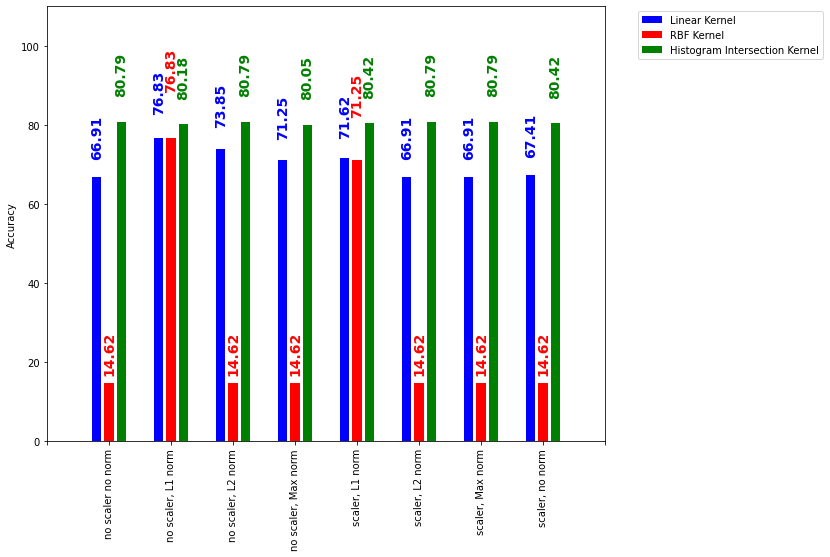

In [46]:
outputPickle = "scale_norm_data.pkl"
file = open(outputPickle, 'rb')
data = cPickle.load(file)
file.close()
for thing in data:
    print(thing)

lin_graph_data = []
rbf_graph_data = []
hist_graph_data = []

lin_graph_data = data[0]
rbf_graph_data = data[1]
hist_graph_data = data[2]

length = len(lin_graph_data)
x = np.arange(length)

categories_labels = ["", "no scaler no norm", "no scaler, L1 norm", "no scaler, L2 norm", "no scaler, Max norm", "scaler, L1 norm", "scaler, L2 norm", "scaler, Max norm", "scaler, no norm"]

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

plt.axis([-1, 8, 0, 110])
width = 0.2
barwidth = 0.15

plt.xticks(rotation=90, ha="center")
ax.set_xticklabels(categories_labels)


ax.bar(x-width, lin_graph_data, barwidth, color='b', label='Linear Kernel')
ax.bar(x, rbf_graph_data, barwidth, color='r', label='RBF Kernel')
ax.bar(x + width, hist_graph_data, barwidth, color='g', label='Histogram Intersection Kernel')

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1));

idx = 0

for i, txt in enumerate(lin_graph_data):
    lin_txt = "{:.2f}".format(txt)
    rbf_txt = "{:.2f}".format(rbf_graph_data[i])
    hist_txt = "{:.2f}".format(hist_graph_data[i])
    ax.annotate(lin_txt, (i - width, 1.15*lin_graph_data[i]), ha='center', va='center', c='b',weight='bold', size=14, rotation=90)
    ax.annotate(rbf_txt, (i , 1.15*rbf_graph_data[i]), ha='center', va='bottom', c='r',weight='bold', size=14, rotation=90)
    ax.annotate(hist_txt, (i+ width, 1.15*hist_graph_data[i]), ha='center', va='center', c='g',weight='bold', size=14, rotation=90)

plt.show()

### Conclusion

As we can see the L1 normalization seems to be the most reliable method to use when normalizing, providing good results across all kernels. The histogram intersection kernel provides very similiar results regardless of normalization or scaler status, while RBF kernel seems to be heavily dependent on being L1 normalized.

## Sift density step impact on results in SVM

In [ ]:
def calculate_vis(step):
    step=step

    today = datetime.now()
    dt_string = today.strftime("%H:%M:%S")
    print(f"{dt_string} started doing step={step}")

    Train_descriptors = []
    Train_label_per_descriptor = []

    for filename,labels in zip(train_images_filenames,train_labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    #     kpt,des=SIFTdetector.detectAndCompute(gray,None)
        des=compute_dense_sift(gray,SIFTdetector, step)
        Train_descriptors.append(des)
        Train_label_per_descriptor.append(labels)

    D=np.vstack(Train_descriptors)

    k=128
    codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    codebook.fit(D)

    visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
    for i in range(len(Train_descriptors)):
        words=codebook.predict(Train_descriptors[i])
        visual_words[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1))

    # knn = KNeighborsClassifier(n_neighbors=37,n_jobs=-1,metric='manhattan')
    # knn.fit(visual_words, train_labels)

    today = datetime.now()
    dt_string = today.strftime("%H:%M:%S")
    print(f"{dt_string} started doing step={step}")
    
    scaler = StandardScaler()
    scaler.fit_transform(visual_words)
    
    lin_clf = svm.LinearSVC(max_iter=2000, C=10)
    lin_clf.fit(visual_words, train_labels)
    
    rbf_svc = svm.SVC(kernel='rbf', C=1000, gamma=0.001)
    rbf_svc.fit(visual_words, train_labels)

    visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
    for i in range(len(test_images_filenames)):
        filename=test_images_filenames[i]
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    #     kpt,des=SIFTdetector.detectAndCompute(gray,None)
        des=compute_dense_sift(gray,SIFTdetector, step)
        words=codebook.predict(des)
        visual_words_test[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1))

    visual_words_test=scaler.transform(visual_words_test)
    
    scores = cross_val_score(lin_clf, visual_words_test, test_labels, cv=5)
    accuracy_linear=scores.mean()*100

    print("linear=",accuracy_linear)

    scores = cross_val_score(rbf_svc, visual_words_test, test_labels, cv=5)
    accuracy_rbf=scores.mean()*100

    print("rbf=",accuracy_rbf)
    
    return accuracy_linear,accuracy_rbf


In [ ]:
data_results_step =[]
steps_to_do=[5,20,50,100,300,500]
for step in steps_to_do:
    accuracy_linear,accuracy_rbf=calculate_vis(step)
    data_results_step.append([step,accuracy_linear,accuracy_rbf,1,1])
    
df=pd.DataFrame(data_results_step, columns=['step','accuracy_linear','accuracy_rbf','normalized','scaler'])    

In [ ]:
with open('Different_densities_analysis.pkl','rb') as f:
    df=cPickle.load(f)

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set(title='Accuracy vs steps', xlim=(0,800), ylim=(0,100))
df2=df
y_rbf=df2.accuracy_rbf
y_lin=df2.accuracy_linear
y_inter=df2.accuracy_inter
print("max for rbf\n",df2[df2.accuracy_rbf==df2.accuracy_rbf.max()])
print("max for linear\n",df2[df2.accuracy_linear==df2.accuracy_linear.max()])
print("max for inter\n",df2[df2.accuracy_inter==df2.accuracy_inter.max()])

ax.plot(df2.step, y_lin, 'r', label='linear')
ax.plot(df2.step, y_rbf, 'g', label='rbf')
ax.plot(df2.step, y_inter, 'b', label='inter')
plt.xlabel('step in dense')
plt.ylabel('accuracy')
ax.legend()

### Conclusion on density versus kernel

We can notice that decreasing the density of SIFT is not improving the result of accuracy for SVM neither for Linear nor RBF kernel nor intersection histogram kernel. Best accuracy shows for step size equals to 5 in dense sift giving Linear accuracy of 66% and RBF accuracy of 79% and Intersection kernel of 80%.

Histogram intersection kernel performs better for step sizes lower than 300 where it crosses the line with RBF kernel and starts performing worse.

In [ ]:
df2

## Spatial Pyramids impact on SVM

In [47]:
def create_pyramid_levels(pyramid):
    step=5

    today = datetime.now()
    dt_string = today.strftime("%H:%M:%S")
    print(f"{dt_string} started doing step={pyramid}")

    Train_descriptors = []
    Train_label_per_descriptor = []
    pyramid_levels = pyramid # level zero has 1 tile, level 1 has 4 tiles => 5 histograms that will be concatenated

    for filename,labels in zip(train_images_filenames,train_labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        # break the image into pieces
        image_cells = []
        for i in range(pyramid_levels+1):

            level_cells = get_pyramid_image_cells(gray,level=i)
            image_cells = image_cells + level_cells
            # compute descriptors for each tile
        Train_descriptors_cell = []
        for cell in image_cells:
            des=compute_dense_sift(cell,SIFTdetector, step)
            Train_descriptors_cell.append(des)

        Train_descriptors.append(Train_descriptors_cell)
        Train_label_per_descriptor.append(labels)

    D=np.vstack([des for descriptors_cells in Train_descriptors for des in descriptors_cells])

    #codebook

    k=128
    codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    codebook.fit(D)

    #creating visual words for Training

    visual_words=np.zeros((len(Train_descriptors),k*21),dtype=np.float32)
    for idx,cells in enumerate(Train_descriptors):

        image_histograms = []
        for id2,image_cell in enumerate(cells):
            cell_words = codebook.predict(image_cell)
            image_histograms.append(normalize(np.bincount(cell_words,minlength=k).reshape(1,-1)))
            # concatenated histogram has k*(1+2**(2*pyramid_levels)) bins
            # normalize(np.bincount(words,minlength=k).reshape(1,-1))

        concatenated_histogram=image_histograms[0].copy()
        for cell_idx in range(1,len(image_histograms)):
            # concatenate histograms
            concatenated_histogram = np.concatenate((concatenated_histogram,image_histograms[cell_idx]))
        visual_words[idx,:]=concatenated_histogram.flatten()
        
    #PCA
    pca = PCA(n_components=(256))
    VWpca = pca.fit_transform(visual_words)

    #SVN kernels

    scaler = StandardScaler()
    scaler.fit_transform(VWpca)

    lin_clf = svm.LinearSVC(max_iter=2000, C=10)
    lin_clf.fit(VWpca, train_labels)

    rbf_svc = svm.SVC(kernel='rbf', C=1000, gamma=0.001)
    rbf_svc.fit(VWpca, train_labels)

    today = datetime.now()
    dt_string = today.strftime("%H:%M:%S")
    print(f"{dt_string} started doing test step={pyramid}")

    #creating SIFT descriptor

    Test_descriptors = []
    Test_label_per_descriptor = []
    # pyramid_levels = 1 # level zero has 1 tile, level 1 has 4 tiles => 5 histograms that will be concatenated
    for filename,labels in zip(test_images_filenames,test_labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        # break the image into pieces
        image_cells = []
        for i in range(pyramid_levels+1):

            level_cells = get_pyramid_image_cells(gray,level=i)
            image_cells = image_cells + level_cells
            # compute descriptors for each tile
        Test_descriptors_cell = []
        for cell in image_cells:
            des=compute_dense_sift(cell,SIFTdetector, step)
            Test_descriptors_cell.append(des)

        Test_descriptors.append(Test_descriptors_cell)
        Test_label_per_descriptor.append(labels)

    #creating visual tests

    visual_words_test=np.zeros((len(Test_descriptors),k*21),dtype=np.float32)
    for idx,cells in enumerate(Test_descriptors):

        image_histograms = []
        for id2,image_cell in enumerate(cells):
            cell_words = codebook.predict(image_cell)
            image_histograms.append(normalize(np.bincount(cell_words,minlength=k).reshape(1,-1)))
            # concatenated histogram has k*(1+2**(2*pyramid_levels)) bins
            # normalize(np.bincount(words,minlength=k).reshape(1,-1))

        concatenated_histogram=image_histograms[0].copy()
        for cell_idx in range(1,len(image_histograms)):
            # concatenate histograms
            concatenated_histogram = np.concatenate((concatenated_histogram,image_histograms[cell_idx]))
        visual_words_test[idx,:]=concatenated_histogram.flatten()



    
    #PCA
    vwtestpca = pca.transform(visual_words_test)
    
    #scaler test
    visual_words_test=scaler.transform(vwtestpca)

    #accuracy for test linear
#     scores = cross_val_score(lin_clf, visual_words_test, test_labels, cv=5)
    scores = cross_val_score(lin_clf, vwtestpca, test_labels, cv=5)
    accuracy_linear=scores.mean()*100

    print("linear=",accuracy_linear)


    #accuracy for test rbf
    scores = cross_val_score(rbf_svc, visual_words_test, test_labels, cv=5)
    accuracy_rbf=scores.mean()*100

    print("rbf=",accuracy_rbf)

    return accuracy_linear,accuracy_rbf

In [ ]:
piramid=[2]
data_pyramid_levels=[]
for level in piramid:
    accuracy_linear,accuracy_rbf=create_pyramid_levels(level)
    data_pyramid_levels.append([level,5,accuracy_linear,accuracy_rbf,1,1])

df_level=pd.DataFrame(data_pyramid_levels, columns=['level','step','accuracy_linear','accuracy_rbf','normalized','scaler'])    

22:28:59 started doing step=2


In [ ]:
with open('Different_pyramid_all.pkl','rb') as f:
    df_all_pyramids=cPickle.load(f)

In [ ]:
df_all_pyramids

Level 1 of pyramid is: all image + 4 tiles

Level 2 of pyramid is: all image + 4 tiles + 16 tiles

Those calculations were running for more than 30min each so in a timely manner it was very hard to debug and  repeatedly run this code for multiple PCA values to find an optimum number of components, but following the common practice of using 0.95 (keep the number of features that represent 95% of the total)we can see that linear accuracy improves where RBF goes a lot worse.